# LCLUC project notebook - Training phase

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import random
import glob
import os
import matplotlib.pyplot as plt
import rasterio
from osgeo import gdal, ogr
from rios import rat
import fiona
import tables

In [2]:
path = '136'
year = '2010'
wdir = 'd:/CSISS/data/' + path + '/' + year
os.chdir(wdir)

### 1. Read in data

In [3]:
data = rasterio.open('mosaic.tif')

### 2. Get mask of valid data bound of all bands

In [4]:
mask = np.ones(data.shape, dtype=bool)
for i in range(1, data.count+1):
    band = data.read(i)
    tmp_mask = (band > 0)
    mask = (mask & tmp_mask)
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [5]:
mask_file = rasterio.open('mask.tif', 'w', driver='GTiff', height=mask.shape[0], width=mask.shape[1], count=1, 
                         dtype='uint8', crs=data.crs, transform=data.transform)
mask_file.write(mask.astype('uint8'), 1)
mask_file.close()

C:\Users\Zhiqi\Miniconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Zhiqi\Miniconda3\envs\geo\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


### 3. Retrieve valid data area by using mask

In [6]:
data_m= np.empty(shape=(data.count, data.shape[0], data.shape[1]), dtype='int')
for i in range(1, data.count+1):
    band = data.read(i).copy()
    band[~mask] = 0
    data_m[i-1] = band
data_m = data_m.swapaxes(0,2)
data_m.shape

(10381, 17691, 6)

In [8]:
# figure = plt.figure()
# plt.imshow(data_masked[0][3000:5000, 1000:3000])

### 4. Read in GLC union clipped raster

Use the union of glc2000 and glc2010 layers to identify potential training points. The essence is to find out the pixel points where no changes happend between 2000 and 2010. These points can be further validated through visual check. 

In [7]:
glc_union = rasterio.open('union-clipped.tif')
glc_band = glc_union.read(1)
glc_rat = pd.read_csv('union-table.txt')     # The atrribute table exported by ArcGIS 
glc_rat.columns

RasterioIOError: 'union-clipped.tif' does not exist in the file system, and is not recognized as a supported dataset name. 

### 5. Randomly generate points in regions where no change happend between 2000 and 2010

#### Get the pixel number ration between classes in the union layer as ratios to use when generating sample points

In [16]:
class_ratio = glc_rat.loc[(glc_rat['glc2000_mo'] == glc_rat['glc2010_mo'])].copy()
class_ratio['ratio'] = class_ratio['Count']/class_ratio['Count'].sum(axis=0)
basenumber = 500/(1 - class_ratio.loc[class_ratio['Value'] == 32]['ratio']).values[0]
class_ratio['number'] = (class_ratio['ratio'] * basenumber).round(0).astype('int')
class_ratio['number'] = np.where(class_ratio['number'] < 80, 80, class_ratio['number'])
class_ratio.loc[17, 'number'] = 120
class_ratio

,OID_,Value,Count,glc2000_mo,glc2010_mo,ratio,number
2,NaN,17,861911.0,30,30,0.010024,80
4,NaN,19,107554.0,90,90,0.001251,80
7,NaN,22,32842431.0,20,20,0.381946,248
12,NaN,27,1674472.0,60,60,0.019474,80
17,NaN,32,19689701.0,10,10,0.228984,200
22,NaN,37,4138162.0,80,80,0.048125,80
31,NaN,53,1944032.0,40,40,0.022608,80
49,NaN,76,516315.0,50,50,0.006005,80
82,NaN,117,24212545.0,255,255,0.281583,183


In [17]:
glc_band = glc_band.reshape((glc_band.shape[0]*glc_band.shape[1], 1), order='C')
classvals = glc_rat.loc[glc_rat['glc2000_mo'] == glc_rat['glc2010_mo']]    # rows that with same classcode in 2000 and 2010
points = {}       # hold the index of the random generated points in the reshaped glc_band data
for val in classvals['Value']:
    ind = np.where(glc_band == val)[0]
    classcode = classvals.loc[classvals['Value'] == val]['glc2000_mo'].values[0]
    samplesize = class_ratio.loc[class_ratio['Value'] == val]['number'].values[0]
    sample = random.sample(list(ind), samplesize)   # use 200 random generated points per class for training data
    points[classcode] = sample


In [18]:
coords = {}   # hold the actual coordinates of random generated points
for key in points.keys():
    coords[key] = []
    for j in points[key]:
        filecoord = np.unravel_index(np.ravel_multi_index((j, 0), glc_band.shape), glc_union.shape)
        coord = glc_union.affine*(filecoord[1], filecoord[0])   # REMEMBER to flip the file coordinates !!!!!!
        coords[key].append(coord)

In [19]:
coords[10][:10]

[(311683.33188243536, 2534421.662677205),
 (315502.21480240003, 2563327.1911201896),
 (325623.8069317373, 2688077.3665057025),
 (347139.9521637334, 2621728.1567498934),
 (316619.93663263356, 2669728.0997927017),
 (365396.0753908816, 2685438.3010732066),
 (296190.46540225344, 2560843.3648307817),
 (316092.12354613445, 2632377.56196573),
 (359962.7053828018, 2775725.3866931847),
 (323481.506757123, 2678700.922263188)]

### 6. Construct a GeoDataFrame using the random generated points and save it to a shapefile

In [20]:
trainPts = gpd.GeoDataFrame()
trainPts['geometry'] = None
trainPts['classcode'] = None

In [21]:
row_num = 0
for key in coords.keys():
    coord = coords[key]
    for c in coord:
        pt = Point(c)
        trainPts.loc[row_num, 'geometry'] = pt
        trainPts.loc[row_num, 'classcode'] = key
        row_num += 1

trainPts.head()

,geometry,classcode
0,POINT (386415.4553649961 2695311.510573603),80
1,POINT (263931.7714685681 2461987.078512347),80
2,POINT (386136.0249074377 2463694.709086315),80
3,POINT (459160.5178160306 2719963.486495977),80
4,POINT (384180.0117045291 2497536.842279498),80


#### Map the 10 class schema into 5 class schema

In [22]:
trainPts['classcode'] = np.where(trainPts['classcode'] == 30, 10, trainPts['classcode']) # 30 to 10
trainPts['classcode'] = np.where(trainPts['classcode'] == 40, 20, trainPts['classcode']) # 40 to 20
trainPts['classcode'] = np.where(trainPts['classcode'] == 50, 90, trainPts['classcode']) # 50 to 90
trainPts['classcode'] = np.where(trainPts['classcode'] == 255, 60, trainPts['classcode']) # 255 to 60
trainPts.head()

,geometry,classcode
0,POINT (386415.4553649961 2695311.510573603),80
1,POINT (263931.7714685681 2461987.078512347),80
2,POINT (386136.0249074377 2463694.709086315),80
3,POINT (459160.5178160306 2719963.486495977),80
4,POINT (384180.0117045291 2497536.842279498),80


In [23]:
trainPts.crs = glc_union.crs
trainPts = trainPts.infer_objects()

#### Add features as new columns to the GeoDataFrame

In [24]:
for i in range(1, data.count+1):
    trainPts[str(i)] = None
trainPts['ndvi'] = None
trainPts['ndwi'] = None
# trainPts['ndwi2'] = None
trainPts['ndbi'] = None
trainPts.head()

,geometry,classcode,1,2,3,4,5,6,ndvi,ndwi,ndbi
0,POINT (386415.4553649961 2695311.510573603),80,None,None,None,None,None,None,None,None,None
1,POINT (263931.7714685681 2461987.078512347),80,None,None,None,None,None,None,None,None,None
2,POINT (386136.0249074377 2463694.709086315),80,None,None,None,None,None,None,None,None,None
3,POINT (459160.5178160306 2719963.486495977),80,None,None,None,None,None,None,None,None,None
4,POINT (384180.0117045291 2497536.842279498),80,None,None,None,None,None,None,None,None,None


#### Get pixel values for the training points

In [25]:
for i in range(1, data.count+1):
    band = data.read(i)
    for j in range(trainPts.shape[0]):
        pt = trainPts.loc[j, 'geometry']
        filecoord = data.index(pt.x, pt.y)
        trainPts.loc[j, str(i)] = band[filecoord]
trainPts.head()

,geometry,classcode,1,2,3,4,5,6,ndvi,ndwi,ndbi
0,POINT (386415.4553649961 2695311.510573603),80,767,974,936,1937,1718,1041,None,None,None
1,POINT (263931.7714685681 2461987.078512347),80,676,800,706,2032,1284,562,None,None,None
2,POINT (386136.0249074377 2463694.709086315),80,648,896,869,1466,913,549,None,None,None
3,POINT (459160.5178160306 2719963.486495977),80,744,852,878,1883,1503,820,None,None,None
4,POINT (384180.0117045291 2497536.842279498),80,433,580,576,1625,819,457,None,None,None


#### Populate the normalized index fields

In [26]:
trainPts['ndvi'] = (trainPts['4'] - trainPts['3'])/(trainPts['4'] + trainPts['3'])
# trainPts['ndwi2'] = float(trainPts['4'] - trainPts['5'])/(trainPts['4'] + trainPts['5']) # for water content in leaf
trainPts['ndwi'] = (trainPts['2'] - trainPts['4'])/(trainPts['4'] + trainPts['2']) # for surface water
trainPts['ndbi'] = (trainPts['4'] - trainPts['5'])/(trainPts['4'] + trainPts['5'])
trainPts.loc[trainPts['classcode'] == 60].head()

,geometry,classcode,1,2,3,4,5,6,ndvi,ndwi,ndbi
568,POINT (280480.2641217484 2447642.981691016),60,1044,1255,1250,973,99,115,-0.124606,0.126571,0.815299
569,POINT (278741.5857191628 2452269.108155038),60,989,1257,1251,921,134,66,-0.151934,0.154270,0.745972
570,POINT (396164.4735509222 2662897.57749683),60,695,963,880,1333,1031,729,0.204700,-0.161150,0.127750
571,POINT (273308.215711083 2493003.859301328),60,1082,1266,1075,550,97,65,-0.323077,0.394273,0.700155
572,POINT (271259.0590223215 2494463.107246355),60,997,1210,984,606,204,115,-0.237736,0.332599,0.496296


##### Save the GeoDataFrame to a shapefile

In [27]:
trainPts.to_file('trainPoints.shp')

### 7. Edit the training points in ArcGIS

Make edit if necessary to correct classcode based on the pixel values on the original image.

### 8. Read in the edited training point shapefile 

HINT: To read in the data properly, you have to manually change the content in the .cpg file associated with the shapefile to 'utf-8' to allow fiona recode successfully.

In [8]:
# read the .cpg file and change the encoding to utf-8
cpg = open('trainPoints.cpg', 'w')
cpg.write('utf-8')
cpg.close()

In [9]:
train = gpd.read_file('trainPoints.shp')
train.tail()

,classcode,1,2,3,4,5,6,ndvi,ndwi,ndbi,savi,ndsi,mndwi,evi,ui,geometry
976,20,813,951,829,2296,2425,1470,0.469440,-0.414229,0.027325,0.704047,0.214374,-0.436611,3.125266,-0.219331,POINT (316636.5221222672 2610825.066227961)
977,20,613,726,606,2001,1429,647,0.535098,-0.467547,-0.166764,0.802493,-0.057538,-0.326218,3.351754,-0.511329,POINT (331363.9213687323 2626005.01412258)
978,20,813,838,740,2000,1720,922,0.459854,-0.409443,-0.075269,0.689655,0.047727,-0.344801,9.170306,-0.368925,POINT (315826.2340433576 2614515.459893471)
979,20,603,672,604,2089,1686,795,0.551430,-0.513220,-0.106755,0.826991,0.083845,-0.430025,3.115820,-0.448682,POINT (323188.1397078257 2601563.493530257)
980,20,599,728,551,2506,1914,888,0.639516,-0.549784,-0.133937,0.959117,0.099010,-0.448902,3.701250,-0.476724,POINT (330220.7787731038 2591519.890109717)


#### Option 1: Update all points

In [10]:
for i in range(1, data.count+1):
    band = data.read(i)
    for j in range(train.shape[0]):
        pt = train.loc[j, 'geometry']
        filecoord = data.index(pt.x, pt.y)
        train.loc[j, str(i)] = band[filecoord]
        #train.loc[j, 'classcode'] = 10
train.tail()

,classcode,1,2,3,4,5,6,ndvi,ndwi,ndbi,savi,ndsi,mndwi,evi,ui,geometry
976,20,846,993,1023,1780,2270,1545,0.469440,-0.414229,0.027325,0.704047,0.214374,-0.436611,3.125266,-0.219331,POINT (316636.5221222672 2610825.066227961)
977,20,866,935,896,1688,1441,757,0.535098,-0.467547,-0.166764,0.802493,-0.057538,-0.326218,3.351754,-0.511329,POINT (331363.9213687323 2626005.01412258)
978,20,819,939,857,1686,1687,1019,0.459854,-0.409443,-0.075269,0.689655,0.047727,-0.344801,9.170306,-0.368925,POINT (315826.2340433576 2614515.459893471)
979,20,790,885,772,1586,1373,753,0.551430,-0.513220,-0.106755,0.826991,0.083845,-0.430025,3.115820,-0.448682,POINT (323188.1397078257 2601563.493530257)
980,20,785,934,852,1911,1708,883,0.639516,-0.549784,-0.133937,0.959117,0.099010,-0.448902,3.701250,-0.476724,POINT (330220.7787731038 2591519.890109717)


In [10]:
train = train.drop('7', axis=1) # in case there is a '7' band information which is absent from SR product

#### Option 2: Update newly added points only

In [9]:
added = train.loc[(train['1'] == 0) & (train['2'] == 0), :]
added.index

Int64Index([1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554,
            1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565,
            1566],
           dtype='int64')

In [14]:
for i in range(1, data.count+1):
    band = data.read(i)
    for j in range(added.index[0], added.index[-1] +1):
        pt = train.loc[j, 'geometry']
        filecoord = data.index(pt.x, pt.y)
        train.loc[j, str(i)] = band[filecoord]
        #train.loc[j, 'classcode'] = 10
train.tail()

,classcode,1,2,3,4,5,6,7,ndvi,ndwi,ndbi,geometry
1562,80,71,31,30,61,66,140,26,NaN,NaN,NaN,POINT (536995.3480673743 2424427.872042765)
1563,80,82,43,50,77,124,147,67,NaN,NaN,NaN,POINT (540932.35594139 2426269.375725772)
1564,80,73,33,31,67,58,143,25,NaN,NaN,NaN,POINT (537535.0991468765 2428872.880932783)
1565,80,73,32,28,64,68,145,31,NaN,NaN,NaN,POINT (541757.8575923933 2430968.385123792)
1566,80,79,36,37,64,73,144,35,NaN,NaN,NaN,POINT (532998.1473646393 2419560.851892058)


#### Update indexes

In [11]:
train['ndvi'] = (train['4'] - train['3'])/(train['4'] + train['3'])
# trainPts['ndwi2'] = float(trainPts['4'] - trainPts['5'])/(trainPts['4'] + trainPts['5']) # for water content in leaf
train['ndwi'] = (train['2'] - train['4'])/(train['4'] + train['2']) # for surface water
train['ndbi'] = (train['5'] - train['4'])/(train['4'] + train['5'])
train['savi'] = 1.5*(train['4'] - train['3'])/(train['4'] + train['3'] + 0.5)
train['ndsi'] = (train['6'] - train['2'])/(train['6'] + train['2']) # band 6 is actually band 7
#train['ii'] = (train['6'] - train['5'])/(train['5'])
train['mndwi'] = (train['2'] - train['5'])/(train['2'] + train['5'])
#train['mdisi'] = (train['6'] - (train['mndwi'] + train['4'] + train['5'])/3)/(train['6'] + (train['mndwi'] + train['4'] + train['5'])/3)
train['evi'] = 2.5*(train['4'] - train['3'])/(train['4'] + 6*train['3'] - 7.5*train['1'] + 1)
train[(train['evi'] == np.inf)] = 10000     # get rid of positive infinity 
train[(train['evi'] == -np.inf)] = -10000   # gett rid of negative infinity
train['ui'] = (train['6'] - train['4'])/(train['6'] + train['4'])

train.tail(80)

,classcode,1,2,3,4,5,6,ndvi,ndwi,ndbi,savi,ndsi,mndwi,evi,ui,geometry
901,60,497,594,370,246,100,104,-0.201299,0.414286,-0.421965,-0.301703,-0.702006,0.711816,0.245934,-0.405714,POINT (414606.8837497761 2317086.862354012)
902,60,840,890,524,348,120,100,-0.201835,0.437803,-0.487179,-0.302579,-0.797980,0.762376,0.156751,-0.553571,POINT (349716.9219389941 2374742.680096894)
903,60,946,1082,792,359,95,144,-0.376195,0.501735,-0.581498,-0.564047,-0.765090,0.838573,0.545890,-0.427435,POINT (380392.1766131819 2399984.564763002)
904,60,838,1057,675,399,107,95,-0.256983,0.451923,-0.577075,-0.385295,-0.835069,0.816151,0.376022,-0.615385,POINT (345804.8955331767 2443420.476999023)
905,60,1010,1056,673,353,137,95,-0.311891,0.498935,-0.440816,-0.467608,-0.834926,0.770327,0.251335,-0.575893,POINT (293303.0173408167 2391104.885778368)
906,60,913,1056,634,352,76,52,-0.286004,0.500000,-0.644860,-0.428789,-0.906137,0.865724,0.262033,-0.742574,POINT (358294.6901244419 2453224.405207934)
907,60,1399,1468,1200,726,379,309,-0.246106,0.338195,-0.314027,-0.369063,-0.652223,0.589605,0.461898,-0.402899,POINT (268775.2327329135 2430908.20206613)
908,60,780,665,453,351,92,60,-0.126866,0.309055,-0.584650,-0.190180,-0.834483,0.756935,0.091727,-0.708029,POINT (251481.5921929109 2327922.554541554)
909,60,841,1059,715,399,107,137,-0.283662,0.452675,-0.577075,-0.425303,-0.770903,0.816467,0.488408,-0.488806,POINT (343383.1649010039 2448760.703521249)
910,60,812,899,573,316,152,62,-0.289089,0.479835,-0.350427,-0.433390,-0.870968,0.710752,0.275161,-0.671958,POINT (380454.2722704171 2396538.255786448)


In [12]:
train.to_file('trainPoints.shp')

In [17]:
train = gpd.read_file('trainPoints.shp')
train.tail()

,classcode,1,2,3,4,5,6,ndvi,ndwi,ndbi,savi,ndsi,mndwi,evi,ui,geometry
976,20,813,951,829,2296,2425,1470,0.469440,-0.414229,0.027325,0.704047,0.214374,-0.436611,3.125266,-0.219331,POINT (316636.5221222672 2610825.066227961)
977,20,613,726,606,2001,1429,647,0.535098,-0.467547,-0.166764,0.802493,-0.057538,-0.326218,3.351754,-0.511329,POINT (331363.9213687323 2626005.01412258)
978,20,813,838,740,2000,1720,922,0.459854,-0.409443,-0.075269,0.689655,0.047727,-0.344801,9.170306,-0.368925,POINT (315826.2340433576 2614515.459893471)
979,20,603,672,604,2089,1686,795,0.551430,-0.513220,-0.106755,0.826991,0.083845,-0.430025,3.115820,-0.448682,POINT (323188.1397078257 2601563.493530257)
980,20,599,728,551,2506,1914,888,0.639516,-0.549784,-0.133937,0.959117,0.099010,-0.448902,3.701250,-0.476724,POINT (330220.7787731038 2591519.890109717)


#### Reshape the training dataframe into scikit-learn-favored data shape, i.e. (n_sample, n_feature)

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
import pickle

In [19]:
X = train.drop(columns=['geometry', 'classcode'], axis=1).as_matrix()
y = train.loc[:, 'classcode'].as_matrix()
X.shape, y.shape

((981, 14), (981,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.35)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((637, 14), (344, 14), (637,), (344,))

In [21]:
train.columns

Index(['classcode', '1', '2', '3', '4', '5', '6', 'ndvi', 'ndwi', 'ndbi',
       'savi', 'ndsi', 'mndwi', 'evi', 'ui', 'geometry'],
      dtype='object')

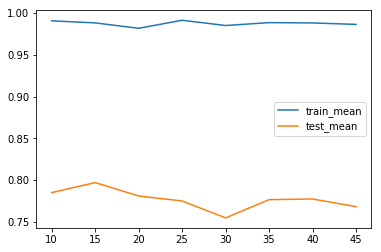

In [22]:
train_score, test_score = validation_curve(RandomForestClassifier(), X_train, y_train, 
                                           param_name='max_depth', param_range=range(10, 50, 5), scoring='f1_macro')
train_mean = train_score.mean(axis=1)
test_mean = test_score.mean(axis=1)
plt.figure()
plt.plot(train_mean)
plt.plot(test_mean)
plt.xticks(range(8), range(10,50, 5))
plt.legend(['train_mean', 'test_mean'])

In [23]:
param_values = {
    'min_samples_leaf': range(1, 6),
    'max_depth': range(10, 40, 5),
    'min_samples_split': range(2, 8)
}
grid_clf = GridSearchCV(RandomForestClassifier(n_estimators=40, random_state=0), param_grid=param_values, scoring='f1_macro', n_jobs=4).fit(X, y)

print('best score: ' + str(grid_clf.best_score_))
grid_clf.best_params_

best score: 0.8295984171534936


{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [31]:
clf = RandomForestClassifier(n_estimators=80, criterion='entropy', n_jobs=4, 
                             min_samples_leaf=1, max_depth=20, min_samples_split=4, max_features='auto', random_state=0
                             )
clf.fit(X_train, y_train)
print('classifier score: ' + str(clf.score(X_test, y_test)))
print('F1 score for train set: ' + str(f1_score(y_train, clf.predict(X_train), average='macro')))
print('F1 score for test set: ' + str(f1_score(y_test, clf.predict(X_test), average='macro')))
confusion_matrix(y_test, clf.predict(X_test))

classifier score: 0.9069767441860465
F1 score for train set: 0.9966507394766779
F1 score for test set: 0.8400873294415827


array([[ 72,   0,   0,   1,   6],
       [  1, 115,   0,   1,   1],
       [  0,   0,  81,   0,   1],
       [  6,   2,   0,  10,   2],
       [  6,   2,   2,   1,  34]], dtype=int64)

In [49]:
clf.feature_importances_, train.columns

(array([0.05402153, 0.06057549, 0.08091807, 0.06833551, 0.06895905,
        0.08262631, 0.08887343, 0.08209956, 0.04158305, 0.09122538,
        0.09666095, 0.11553812, 0.0239328 , 0.04465074]),
 Index(['classcode', '1', '2', '3', '4', '5', '6', 'ndvi', 'ndwi', 'ndbi',
        'savi', 'ndsi', 'mndwi', 'evi', 'ui', 'geometry'],
       dtype='object'))

In [32]:
clf_file = open(wdir + '/clf.pkl', 'wb')
pickle.dump(clf, clf_file)
clf_file.close()

## Stop here

In [114]:
X_data = np.reshape(data_m, (data_m.shape[0]*data_m.shape[1], data_m.shape[2]), order='C')
X_data.shape

(260850951, 7)

In [117]:
np.unravel_index(np.ravel_multi_index((10, 0), X_data.shape), data_m.shape)

(0, 10, 0)

In [76]:
X_datafile = tables.open_file('X_data.hdf5', 'w')
X_datafile.create_array(X_datafile.root, 'data', X_data)
X_datafile.close()

In [79]:
%reset -f X_data

In [50]:
X_datafile = tables.open_file('X_data.hdf5', 'r')
X_data = X_datafile.root.data

(260850951, 7)

In [81]:
X_target = pd.DataFrame(X_data)
# X_target['ndvi'] = (X_target.iloc[:, 3] - X_target.iloc[:, 2])/(X_target.iloc[:, 3] + X_target.iloc[:, 2])
# X_target['ndwi'] = (X_target.iloc[:, 1] - X_target.iloc[:, 3])/(X_target.iloc[:, 1] + X_target.iloc[:, 3])
# X_target['ndbi'] = (X_target.iloc[:, 3] - X_target.iloc[:, 4])/(X_target.iloc[:, 3] + X_target.iloc[:, 4])
# X_1d = X_target[(X_target.iloc[:, 0] != 0) & (X_target.iloc[:, 1] != 0)]
# X_1d

TypeError: data argument can't be an iterator

In [20]:
#np.unravel_index(np.ravel_multi_index((X_1d.iloc[2, :].name, 0), X_data.shape), data_m.shape)

In [21]:
X_array = X_1d.as_matrix()
%reset X_1d
X_array

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  x_1d, please run `%reset?` for details


array([[  7.70000000e+01,   2.90000000e+01,   2.40000000e+01, ...,
         -2.30769231e-01,   3.18181818e-01,   2.00000000e-01],
       [  7.70000000e+01,   2.90000000e+01,   2.40000000e+01, ...,
         -2.63157895e-01,   3.48837209e-01,   1.66666667e-01],
       [  7.70000000e+01,   2.70000000e+01,   2.30000000e+01, ...,
         -2.43243243e-01,   3.17073171e-01,   2.17391304e-01],
       ..., 
       [  8.10000000e+01,   3.60000000e+01,   3.70000000e+01, ...,
          7.50000000e-02,  -8.86075949e-02,  -9.47368421e-02],
       [  7.90000000e+01,   3.50000000e+01,   3.50000000e+01, ...,
          1.35802469e-01,  -1.35802469e-01,  -5.15463918e-02],
       [  7.90000000e+01,   3.60000000e+01,   3.50000000e+01, ...,
          9.09090909e-02,  -7.69230769e-02,  -1.42857143e-01]])

### 10. Classify image and save result to a new TIFF image

In [22]:
y_array = np.zeros(shape=(X_array.shape[0], ))
for i in range(int(len(X_array)/5000000) +1):
    if (i+1)*5000000 <= X_array.shape[0]:
        X_slice = X_array[i*5000000:(i+1)*5000000, :]
        y_predict = clf.predict(X_slice)
        y_array[i*5000000:(i+1)*5000000] = y_predict
    else:
        X_slice = X_array[i*5000000:, :]
        y_predict = clf.predict(X_slice)
        y_array[i*5000000:] = y_predict

In [23]:
y_array = y_array.astype('uint8')

In [24]:
result = np.empty(shape=(X_data.shape[0],), dtype='uint8')

In [25]:
for i, ind in enumerate(X_1d.index):
    result[ind] = y_array[i]
result

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [26]:
result_2d = np.reshape(result, (data_m.shape[0], data_m.shape[1]), order='C')
result_2d = result_2d.swapaxes(0,1)
result_2d.shape

(12301, 8911)

In [27]:
result_file = rasterio.open('output.tif', 'w', driver='GTiff', height=result_2d.shape[0], width=result_2d.shape[1], count=1, 
                         dtype='uint8', crs=data.crs, transform=data.transform)

C:\Users\Zhiqi\Miniconda3\envs\geo_dev\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Zhiqi\Miniconda3\envs\geo_dev\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [28]:
result_file.write(result_2d, 1)

In [29]:
result_file.close()

### 11. Smooth image and save to a new image

In [30]:
from skimage.filters.rank import modal
from skimage.morphology import square

In [31]:
image = rasterio.open('output.tif')
band = image.read(1)
band.shape, mask.shape

((12301, 8911), (12301, 8911))

In [32]:
smoothed = modal(band, selem=square(3), mask=mask)

In [33]:
smoothed_file = rasterio.open('end.tif', 'w', driver='GTiff', height=smoothed.shape[0], width=smoothed.shape[1], count=1, 
                         dtype='uint8', crs=data.crs, transform=data.transform)
smoothed_file.write(smoothed, 1)
smoothed_file.close()

C:\Users\Zhiqi\Miniconda3\envs\geo_dev\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Zhiqi\Miniconda3\envs\geo_dev\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
